In [2]:
import h5py
from torchaudio.datasets import LJSPEECH, LIBRISPEECH

In [3]:
dataset = LIBRISPEECH('../../datasets', download=True, url='test-other')

In [4]:
from tqdm.notebook import tqdm

with h5py.File('../../datasets/librispeech.h5', 'a') as f:
    for split in ['test-other']:
        dataset = LIBRISPEECH('../../datasets', download=True, url=split)
        split_group = f.create_group(split)
        
        for idx, item in tqdm(enumerate(dataset), total=len(dataset)):
            group = split_group.create_group(str(idx))
            group.create_dataset('wav', data=item[0].numpy()[0], dtype='f4', compression='gzip')
            str_ds = group.create_dataset('text', data=item[2], dtype=h5py.string_dtype())


In [ ]:
with h5py.File('../../datasets/librispeech.h5', 'a') as f:
    split_group = f.create_group('train-clean-100')
    
    with h5py.File('../../datasets/librispeech-train-clean-100.h5', 'r') as train:
        for k in train.keys():
            group = split_group.create_group(k)
            group.create_dataset('wav', data=train[k]['wav'][:], dtype='f4', compression='gzip')
            str_ds = group.create_dataset('text', data=train[k]['text'].asstr()[()],
                                          dtype=h5py.string_dtype())

In [3]:
f = h5py.File('../../datasets/librispeech.h5', 'r')

In [12]:
f['train-clean-100']['1']['wav'][:],
#f['train-clean-100']['1']['text'].asstr()[()]

(array([-0.00585938, -0.00445557, -0.00671387, ...,  0.00067139,
         0.00341797,  0.00466919], dtype=float32),)

In [20]:
import numpy as np
lens = []
target_lens = []
keys = list(f.keys())
for k in tqdm(keys):
    lens.append(len(f[k]['wav'][:]) / 16000)
    target_lens.append(len(f[k]['text'].asstr()[()]))

In [39]:
lens = np.array(lens)
target_lens = np.array(target_lens)

In [41]:
lens[10 > target_lens]

array([1.525, 2.16 , 2.22 , 2.105])

(array([1.0580e+03, 1.5210e+03, 1.5160e+03, 1.8530e+03, 4.1720e+03,
        1.2068e+04, 6.3460e+03, 3.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([ 1.41  ,  3.7215,  6.033 ,  8.3445, 10.656 , 12.9675, 15.279 ,
        17.5905, 19.902 , 22.2135, 24.525 ]),
 <BarContainer object of 10 artists>)

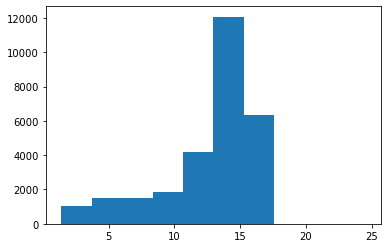

In [28]:
import matplotlib.pyplot as plt

plt.hist(lens)

In [ ]:
with h5py.File('../../datasets/librispeech-train-clean-100.h5', 'r') as f:
    with open('../../datasets/train_corpus.txt', 'w+') as out:
        for k in tqdm(f.keys(), total=len(dataset)):
            text = f[k]['text'].asstr()[()]
            print(text, file=out)

In [ ]:
import torch
import math

def CosineWithWarmup(
        optimizer, num_warmup_steps, num_training_steps, num_cycles=0.5, last_epoch=-1
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

In [ ]:
m = torch.nn.Linear(23, 23)
opt = torch.optim.Adam(m.parameters(), lr=0.01)
p = CosineWithWarmup(opt, 100, 300)

In [ ]:
lrs = []

for i in range(300):
    lrs.append(p.get_last_lr()[0])
    p.step()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!pip install youtokentome

In [ ]:
!pip install cython

In [ ]:
import youtokentome as yttm

yttm.BPE.train(data='../../datasets/train_corpus.txt', vocab_size=10000,
               model='../../bpe_model', pad_id=0, unk_id=1, bos_id=2, eos_id=3)

In [ ]:
model = yttm.BPE(model='../../bpe_model')

In [ ]:
model.vocab()

In [14]:
import youtokentome as yttm

In [16]:
yttm.BPE.train(data='../../datasets/train_corpus.txt', vocab_size=32,
               model='../../bpe_model__', pad_id=0, unk_id=1, bos_id=2, eos_id=3)

Training parameters
  input: ../../datasets/train_corpus.txt
  model: ../../bpe_model__
  vocab_size: 32
  n_threads: 8
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 27
number of deleted characters: 0
number of unique characters left: 27
model saved to: ../../bpe_model__


In [17]:
model = yttm.BPE(model='../../bpe_model__')

In [21]:
sorted(model.vocab())

["'",
 '<BOS>',
 '<EOS>',
 '<PAD>',
 '<UNK>',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 '▁']